<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/Robin/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)





In [ ]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

%tensorflow_version 1.x
import tensorflow as tf

import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.


## **1. Datasets**

### **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


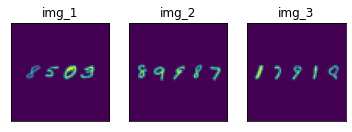

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [ ]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

In [ ]:
print(type(test_images))

<class 'numpy.ndarray'>


In [ ]:
# # Normalization
# def data_normalized(x):
#   scaled_x = x.astype('float32') / 255.0
#   return scaled_x

# train_images = data_normalized(train_images)

### **1.2 Baseline Model**

In [ ]:
# train/validation split
# Select 30% random images from the training set for validation
idx = np.random.choice(range(0, len(train_images)), size=int(len(train_images)*0.30), replace=False)
X_val, Y_val = train_images[idx], train_labels[idx]

# training set = the Complement set 
X_train = np.delete(train_images, idx, axis=0)
Y_train = np.delete(train_labels, idx, axis=0)

print("Training", X_train.shape, Y_train.shape)
print('Validation', X_val.shape, Y_val.shape)


Training (39200, 64, 64, 1) (39200, 5)
Validation (16800, 64, 64, 1) (16800, 5)


In [ ]:
# Construct model
def conv_layer(prev_layer, n_channels, f_size, n_filters, w, pooling=True):
    # Create weights and biases
    w_s = tf.get_variable(w, shape=[f_size, f_size, n_channels, n_filters],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.Variable(tf.constant(1.0, shape=[n_filters]))
    layer = tf.nn.conv2d(prev_layer, w_s, strides=[1, 1, 1, 1], padding='VALID')
    layer = tf.nn.relu(layer + biases)
    # if using pooling
    if pooling:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    return layer, w_s


def flat_layer(layer):
    shape = layer.get_shape()
    feature_no = shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, feature_no])

    return layer_flat, feature_no


def fc_layer(prev_layer, ins, outs, w, relu=True):
    w_s = tf.get_variable(w, shape=[ins, outs],initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.Variable(tf.constant(1.0, shape=[outs]))
    layer = tf.matmul(prev_layer, w_s) + biases
    # if using RELU activation
    if relu:
        layer = tf.nn.relu(layer)

    return layer

# input image size = 64*64*1
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1), name='x')
y_true = tf.placeholder(tf.int64, shape=[None, 5], name='y_true')
keep_prob = tf.placeholder(tf.float32)

# CNN layers
conv_1, w_c1 = conv_layer(x, 1, 5, 16, 'w_c1', True) # 30*30*16
conv_2, w_c2 = conv_layer(conv_1, 16, 5, 32, 'w_c2', True) # 13*13*32
conv_3, w_c3 = conv_layer(conv_2, 32, 5, 64, 'w_c3', False) # 9*9*64
dropout = tf.nn.dropout(conv_3, keep_prob) #9*9*64
flatten, num_features = flat_layer(dropout)
fully_connected = fc_layer(flatten, num_features, 64, 'w_fc1', relu=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# the last layer: softmax layer for multi-classification 
def softmax_layer(prev_layer, num_inputs, num_outputs, weight_name):
    weights = tf.get_variable(weight_name, shape=[num_inputs, num_outputs],initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.Variable(tf.constant(1.0, shape=[num_outputs]))
    pred = tf.matmul(prev_layer, weights) + biases
    
    return pred, weights

# 11 labels for digits
pred_1, w_s1 = softmax_layer(fully_connected, 64, 11, 'w_s1')
pred_2, w_s2 = softmax_layer(fully_connected, 64, 11, 'w_s2')
pred_3, w_s3 = softmax_layer(fully_connected, 64, 11, 'w_s3')
pred_4, w_s4 = softmax_layer(fully_connected, 64, 11, 'w_s4')
pred_5, w_s5 = softmax_layer(fully_connected, 64, 11, 'w_s5')

y_pred_cls = tf.transpose(tf.argmax([pred_1, pred_2, pred_3, pred_4, pred_5], dimension=2))

Instructions for updating:
Use the `axis` argument instead


In [ ]:
# optimzer setups

loss = 0
i = 0
for pred in [pred_1, pred_2, pred_3, pred_4, pred_5]:
  loss = loss + tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=y_true[:, i]))
  i = i+1


step_count = tf.Variable(0)
# grid search: applying expoential decay on LR, 0.01 to 0.99
learning_rate = tf.train.exponential_decay(0.01, step_count, 10000, 0.99)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=step_count)

session = tf.Session()
session.run(tf.initialize_all_variables())

# TODO: grid seartch on batch sizes
# mini-batches desecnt
# batch_size = 32
batch_size = 16

# dropout connections between the two linear layers to reduce overfitting; set dropout probability as 0.5
dropout = 0.5

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
# run
total_iterations = 0


def accuracy(pred, label_true):
    return (100.0 * np.sum(pred == label_true) / pred.shape[1] / pred.shape[0])


def run(iter_count):
    global total_iterations
    for step in range(iter_count):
        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        mini_batch_img = X_train[offset:(offset + batch_size), :, :, :]
        mini_batch_labels = Y_train[offset:(offset + batch_size), :]
        feed_dict_train = {x: mini_batch_img, y_true: mini_batch_labels, keep_prob: dropout}

        # Run the optimizer on mini-batches
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Show status every 5000 iterations.
        if step % 5000 == 0:
            # accuracy of the training set.
            batch_predictions = session.run(y_pred_cls, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, accuracy(batch_predictions, mini_batch_labels)))
            # accuracy of the validation set
            val_predictions = session.run(y_pred_cls, {x: X_val, y_true: Y_val, keep_prob: 1.})
            print("Validation accuracy: %.4f" % accuracy(val_predictions, Y_val))

    total_iterations += iter_count

    print('Done!')

In [ ]:
run(250000)

Minibatch accuracy at step 0: 21.2500
Validation accuracy: 21.8786
Minibatch accuracy at step 5000: 95.0000
Validation accuracy: 94.7560
Minibatch accuracy at step 10000: 97.5000
Validation accuracy: 96.9619
Minibatch accuracy at step 15000: 96.2500
Validation accuracy: 97.5107
Minibatch accuracy at step 20000: 98.7500
Validation accuracy: 97.8250
Minibatch accuracy at step 25000: 97.5000
Validation accuracy: 97.9333
Minibatch accuracy at step 30000: 100.0000
Validation accuracy: 98.1226
Minibatch accuracy at step 35000: 93.7500
Validation accuracy: 98.2298
Minibatch accuracy at step 40000: 100.0000
Validation accuracy: 98.2000
Minibatch accuracy at step 45000: 100.0000
Validation accuracy: 98.3310
Minibatch accuracy at step 50000: 98.7500
Validation accuracy: 98.2893
Minibatch accuracy at step 55000: 98.7500
Validation accuracy: 98.3619
Minibatch accuracy at step 60000: 100.0000
Validation accuracy: 98.4083
Minibatch accuracy at step 65000: 100.0000
Validation accuracy: 98.3964
Miniba

### **1.3 Grid Search**

In [ ]:
def optimizer_setup(learning_rate):
  loss = 0
  i = 0
  for pred in [pred_1, pred_2, pred_3, pred_4, pred_5]:
    loss = loss + tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=y_true[:, i]))
    i = i+1
  
  step_count = tf.Variable(0)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=step_count)
  return optimizier

In [ ]:
def get_accuracy(iter_count, batch_size, dropout, learning_rate, x_train, y_train, x_val, y_val):
  #batch size, dropout, and learning rate are floats
    global total_iterations
    for step in range(iter_count):
        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        mini_batch_img = x_train[offset:(offset + batch_size), :, :, :]
        mini_batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict_train = {x: mini_batch_img, y_true: mini_batch_labels, keep_prob: dropout}
        optimizer = optimizer_setup(learning_rate)

        # Run the optimizer on mini-batches
        session.run(optimizer, feed_dict=feed_dict_train)
        acc = accuracy(val_predictions, y_val))
    return acc

In [ ]:
def grid_search(batch_size, dropout, learning_rate, x_train, y_train, x_val, y_val):
  #batch size, dropout, and learning rate are lists
  max_accuracy=-np.inf
  best_parameter={}
  max_accuracy=-np.inf
  accuracy = 0.0

  #These lists store the numbers
  batch_size_list = []
  dropout_list = []
  learning_rate_list = []
  accuracy_list = []

  for b in batch_size:
    for d in dropout:
      for l in learning_rate:
        accuracy = get_accuracy(250000, b, d, l, x_train, y_train, x_val, y_val)
        batch_size_list.append(b)
        dropout_list.append(b)
        learning_rate_list.append(l)
        accuracy_list.append(accuracy)

  index = np.zeros(10)
  for i in list(range(0, 10)):
    max_accuracy = max(accuracy_list)
    index[i] = accuracy_list.index(max_accuracy)
    b = batch_size_list[index[i]]
    d = dropout_list[index[i]]
    l = learning_rate_list[index[i]]
    print("batch size:",b,"  dropout:",b,"   leanrning rate:",l, "Accuracy:",max(accuracy))
    accuracy_list.pop(max_accuracy)
  
  best_parameter['batch_size'] = batch_size_list[index[0]]
  best_parameter['dropout'] = dropout_list[index[0]]
  best_parameter['learning_rate'] = learning_rate_list[index[0]]
  print('MAX Accuracy: ', accuracy_list[index[0]])
  print("Best parameter: ", best_parameter)
  return best_parameter

In [ ]:
a = np.arange(0.0, 1.0, 0.01)
dropout = np.round(a, 2).tolist()
learning_rate = np.round(a, 2).tolist()
batch_size = list(range(1, 100))

In [ ]:
best_parameter = grid_search(batch_size, dropout, learning_rate, x_train, y_train, x_val, y_val)

## Apply on the  test set

In [ ]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict={x: test_images, keep_prob: 1.0})

print(test_pred)

output = []
for i in range(len(test_pred)):
  string = str(test_pred[i][0])+str(test_pred[i][1])+str(test_pred[i][2])+str(test_pred[i][3])+str(test_pred[i][4])
  output.append(string)

print(output)

d = {'Id': np.arange(len(test_images)), 'Label': output}
df = pd.DataFrame(data=d)

from google.colab import files
df.to_csv('sample.csv',index=False) 
files.download('sample.csv')


[[ 9 10 10 10 10]
 [ 0  1  7  8 10]
 [ 1  4  0  8  3]
 ...
 [ 3 10 10 10 10]
 [ 4  1  9  7 10]
 [ 5  8  3  0  9]]
['910101010', '017810', '14083', '010101010', '467810', '010101010', '6921010', '37101010', '48267', '966010', '2201010', '110101010', '109310', '04101010', '619510', '210101010', '095710', '780410', '87674', '4291010', '1901010', '4431010', '34836', '24101010', '693210', '60101010', '2251010', '733510', '510101010', '010101010', '039910', '810101010', '9171010', '373010', '22101010', '5111010', '910101010', '17764', '410101010', '72032', '3261010', '60689', '48282', '0561010', '6161010', '8961010', '876010', '740110', '4571010', '09101010', '410101010', '8841010', '5791010', '94640', '010101010', '70990', '9051010', '14101010', '93802', '610101010', '891410', '3031010', '97125', '11101010', '810101010', '6001010', '353310', '27132', '93101010', '65101010', '52296', '421210', '100710', '69101010', '710101010', '93101010', '710101010', '14101010', '61232', '4161010', '03269'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>